# Process concatenated ts files from AWS for orca calls below 1khz
Isabelle Brandicourt 11.1.2024

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ffmpeg
from scipy import signal
from scipy.signal import spectrogram, butter, filtfilt, welch
from scipy.io import wavfile
import warnings

import pandas as pd # type: ignore
from pyproj import Proj # type: ignore

warnings.filterwarnings("error")
warnings.filterwarnings('ignore')

### Set parameters

- Start and end dates need to align with a start and end date associated with a ts file that is already located on your computer in a folder called ts_chunks, in the same directory as this file.
- You won't be able to see any whales in the ts files if they're longer than 10-ish seconds, so need to listen to the ts file and find the approximate time stamp, then use ss (start time) and dur (duration) to clip the ts file.
- Lowcut and highcut correspond to the bandpass filter parameters. 

In [9]:
start_date = '2024-10-29_20.26.30'
end_date = '2024-10-29_20.26.40'
ts_file_path = f"ts_chunks/{start_date}_to_{end_date}.ts"

name = f"{start_date}_to_{end_date}.wav"
pic_name = f"{start_date}_to_{end_date}.png"

ss = 5
dur = 10

lowcut, highcut = 200, 6000

In [10]:
audio_file = ffmpeg.input(ts_file_path, ss=ss, t=dur).output(name).run(overwrite_output=True, quiet=True, capture_stdout=True, capture_stderr=True)

### Set up filtering

- butter_bandpass and bandpass_filter : applies nyquist freq to normalize cutoffs and bandpass the data
- apply_fft : gets fast ft of the data

In [11]:
def butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def apply_fft(filtered_data, sample_rate):
    # Perform FFT on the filtered signal
    n = len(filtered_data)
    fft_data = np.fft.fft(filtered_data)
    freqs = np.fft.fftfreq(n, 1 / sample_rate)
    
    # Only keep the positive frequencies (real part)
    fft_data = np.abs(fft_data[:n // 2])
    freqs = freqs[:n // 2]
    
    # Normalize and apply log scale for better contrast
    fft_data = np.log(fft_data + np.finfo(float).eps)
    return freqs, fft_data

### Start processing the data and plot the PSDs

Sample rate: 48000, Audio data shape: (483069, 2)


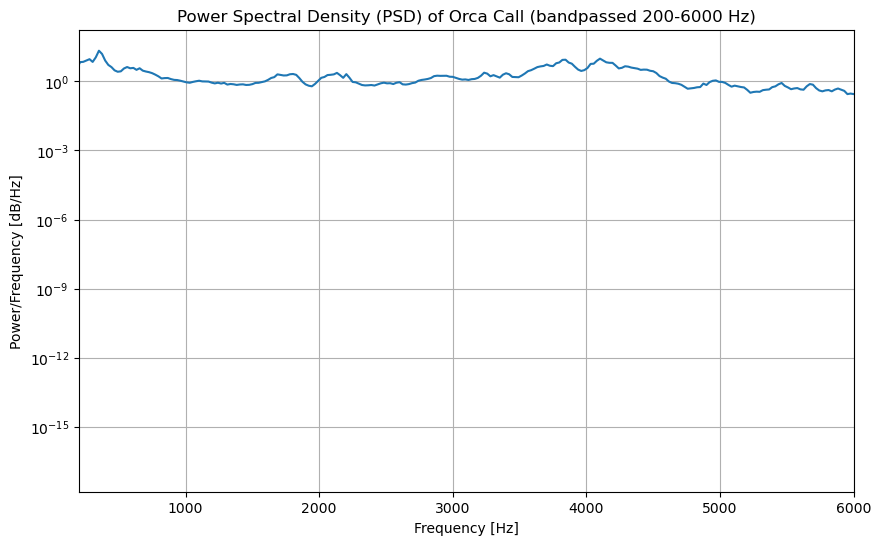

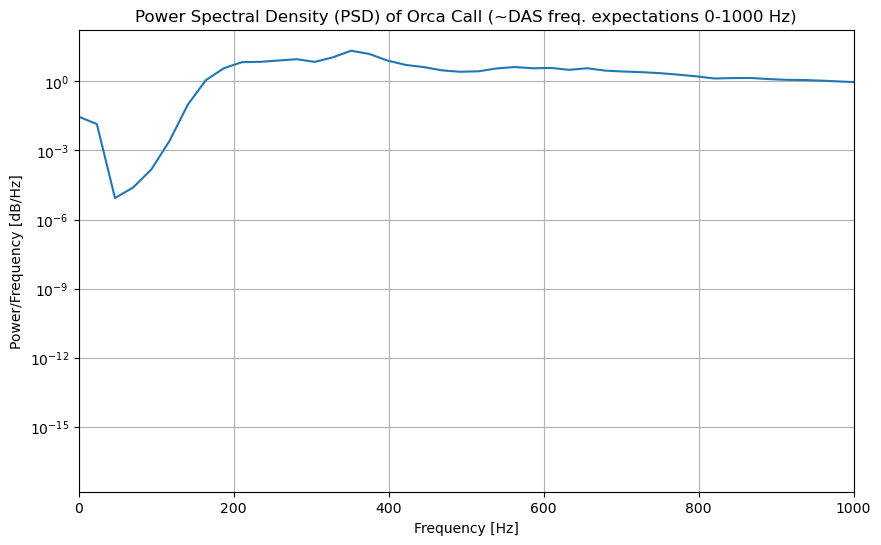

In [12]:
if audio_file:
        sample_rate, audio_data = wavfile.read(name)
        print(f"Sample rate: {sample_rate}, Audio data shape: {audio_data.shape}")

        # If stereo, take only the first channel
        if audio_data.ndim > 1:
            audio_data = audio_data[:, 0]

        # Apply bandpass filter
        filtered_data = butter_bandpass(audio_data, lowcut, highcut, sample_rate)

        # Calculate Power Spectral Density (PSD) with Welch's method
        frequencies, psd = welch(filtered_data, fs=sample_rate, nperseg=2048)

        # Plot PSD with bandpass frequency limits
        plt.figure(figsize=(10, 6))
        plt.semilogy(frequencies, psd)
        plt.xlim([lowcut, highcut])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Power/Frequency [dB/Hz]')
        plt.title(f'Power Spectral Density (PSD) of Orca Call (bandpassed {lowcut}-{highcut} Hz)')
        plt.grid(True)
        plt.show()

        # Plot PSD with DAS optimistic frequency limits
        plt.figure(figsize=(10, 6))
        plt.semilogy(frequencies, psd)
        plt.xlim([0, 1000])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Power/Frequency [dB/Hz]')
        plt.title(f'Power Spectral Density (PSD) of Orca Call (~DAS freq. expectations 0-1000 Hz)')
        plt.grid(True)
        plt.show()

### Plot the FFT 

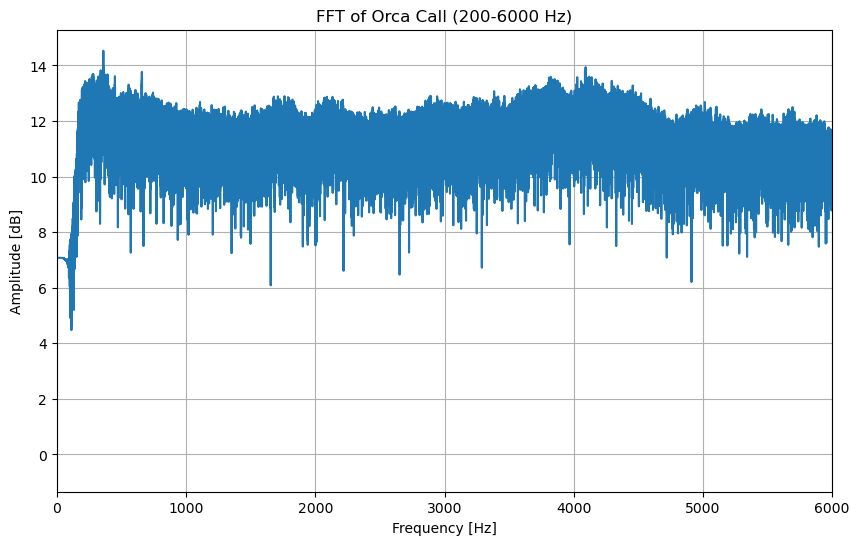

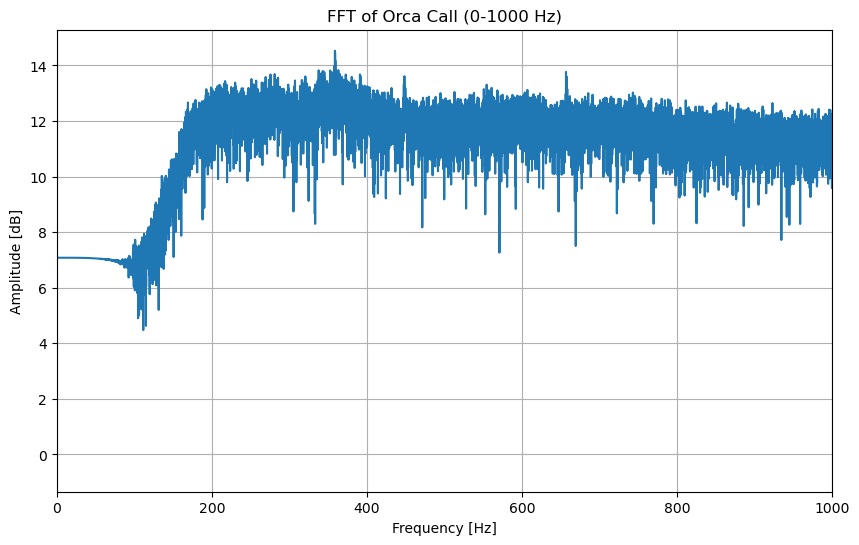

In [13]:
if audio_file:
    # Apply FFT to increase contrast
    freqs, fft_data = apply_fft(filtered_data, sample_rate)

    # Plot the FFT result (amplitude vs frequency) for the bandpassed region
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, fft_data)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.xlim([0, highcut])
    plt.title(f'FFT of Orca Call ({lowcut}-{highcut} Hz)')
    plt.grid(True)
    plt.show()
    
    # Plot the FFT result (amplitude vs frequency) for the optimistic DAS region
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, fft_data)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.xlim([0, 1000])
    plt.title(f'FFT of Orca Call (0-1000 Hz)')
    plt.grid(True)
    plt.show()

### Plot spectrogram

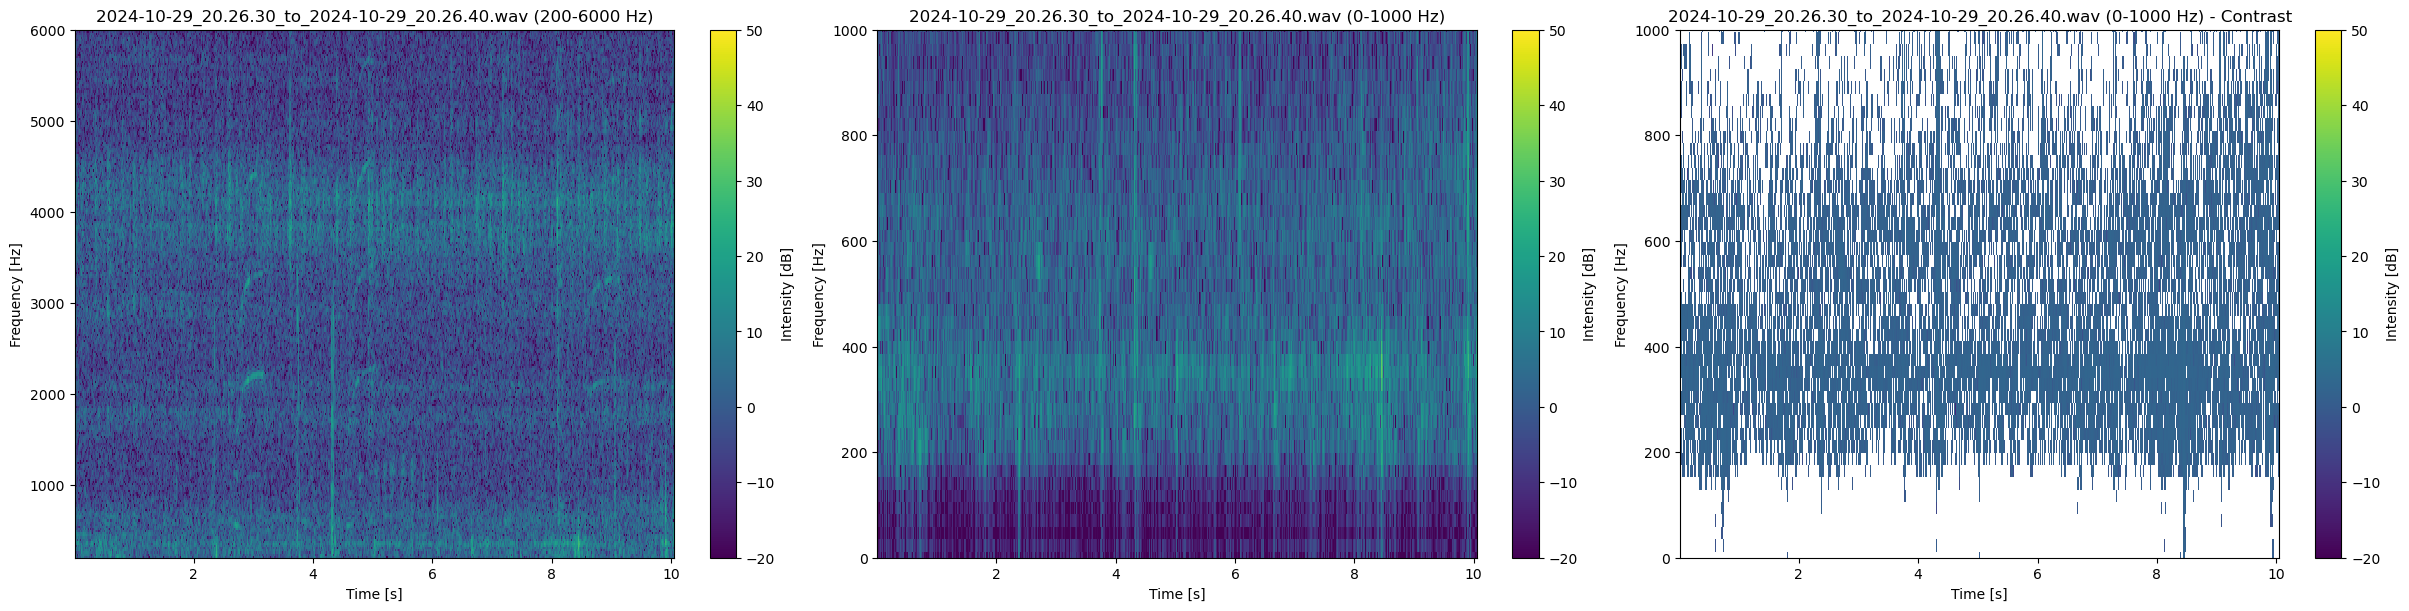

In [14]:
if audio_file:
    # Generate the spectrogram
    frequencies, times, Sxx = spectrogram(filtered_data, fs=sample_rate, nperseg=1024, noverlap=512, nfft=2048)
    Sxx_dB = 10 * np.log10(Sxx + np.finfo(float).eps)  # Convert to dB scale for better visualization
        # Increase the contrast by adjusting the dynamic range in dB
    Sxx_dB_contrast = np.log(Sxx_dB + 1e-5) * 1  # You can adjust contrast_factor to control the strength of the contrast

    fig, axs = plt.subplots(1, 3, figsize=(24, 6), constrained_layout=True)

    # Plot the spectrogram of the entire bandpassed section with no added contrast
    mesh1 = axs[0].pcolormesh(times, frequencies, Sxx_dB, shading='auto', cmap='viridis', vmax=50, vmin=-20)
    fig.colorbar(mesh1, ax=axs[0], label='Intensity [dB]')
    axs[0].set_ylabel('Frequency [Hz]')
    axs[0].set_xlabel('Time [s]')
    axs[0].set_title(f'{name} ({lowcut}-{highcut} Hz)')
    axs[0].set_ylim([lowcut, highcut])

    # Plot the spectrogram with a full frequency range and no added contrast
    mesh2 = axs[1].pcolormesh(times, frequencies, Sxx_dB, shading='auto', cmap='viridis', vmax=50, vmin=-20)
    fig.colorbar(mesh2, ax=axs[1], label='Intensity [dB]')
    axs[1].set_ylabel('Frequency [Hz]')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_title(f'{name} (0-1000 Hz)')
    axs[1].set_ylim([0, 1000])

    # Plot the spectrogram with added contrast
    mesh3 = axs[2].pcolormesh(times, frequencies, Sxx_dB_contrast, shading='auto', cmap='viridis', vmax=50, vmin=-20)
    fig.colorbar(mesh3, ax=axs[2], label='Intensity [dB]')
    axs[2].set_ylabel('Frequency [Hz]')
    axs[2].set_xlabel('Time [s]')
    axs[2].set_title(f'{name} (0-1000 Hz) - Contrast')
    axs[2].set_ylim([0, 1000])

    plt.show()